## Imports

In [1]:
from copy import deepcopy as copy
import numpy as np
import pandas as pd
from random import seed
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import metrics
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier

import torch
from torchvision import transforms
import torchvision.datasets as datasets

## Questão 1

In [2]:
data = np.loadtxt('banana/banana copy.dat', delimiter=',')
class Dataset:
    def __init__(self, data):
        self.X = data[:, :-1]
        self.y = data[:, -1]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=3) # 70% training and 30% test
ds = Dataset(data)

In [3]:
ds.X_train

array([[ 1.54e+00, -3.36e-01],
       [-1.24e-03, -9.38e-01],
       [-6.44e-01, -7.80e-01],
       ...,
       [-2.01e-01,  2.87e-01],
       [-9.74e-01,  1.05e+00],
       [ 1.23e+00,  4.58e-01]])

In [4]:
def train_test_model(df, _kernel, _cv, _gamma=1, _degree=3):
    ds = copy(df)
    if _kernel == 'linear':
        model = svm.SVC(kernel=_kernel)
    elif _kernel in ['rbf', 'sigmoid']:
        model = svm.SVC(kernel=_kernel, gamma=_gamma)
    elif _kernel == 'poly':
        model = svm.SVC(kernel=_kernel, degree=_degree)

    model.fit(ds.X_train, ds.y_train)

    ds.y_pred = model.predict(ds.X_test)
    E_in = 1-metrics.accuracy_score(ds.y_test, ds.y_pred)
    E_out = np.sum(np.sign(ds.y_test - ds.y_pred))/len(ds.y_test)

    score_cv = cross_val_score(model, ds.X_train, ds.y_train, cv=_cv).mean()
    mse = metrics.mean_squared_error(ds.y_test, ds.y_pred)
    
    if _kernel not in ['rbf', 'sigmoid']:
        _gamma = np.NaN
    if _kernel != 'poly':
        _degree = np.NaN

    results = pd.DataFrame({
                        'kernel': _kernel, 
                        'cv': _cv, 
                        'gamma': _gamma, 
                        'degree': _degree, 
                        'E_in': E_in,
                        'E_out': E_out,
                        'mean_score_cv': score_cv,
                        }, index=[0])
    return ds, results, model

In [5]:
results = pd.DataFrame(columns=['kernel', 'cv', 'gamma', 'degree', 'E_in', 'E_out', 'mean_score_cv'])
bd = []
models = []
titles = []

for m in ['rbf', 'sigmoid', 'linear', 'poly']:
    for g in [ 1, 0.5, 0.01]:
        for k in [2, 5, 10]:
            df, r, model = train_test_model(df=ds, _kernel=m, _cv=k, _gamma=g, _degree=3)
            bd.append(df)
            results = pd.concat([results, r], ignore_index=True)
            titles.append(f'kernel={m}; k={k}; gamma={g}')
            models.append(model)
        if m in ['linear', 'poly']:
            break

In [224]:
results.to_csv('exp1_results.csv')
results

,kernel,cv,gamma,degree,E_in,E_out,mean_score_cv
0,rbf,2,1,NaN,0.094969,0.034591,0.903774
1,rbf,5,1,NaN,0.094969,0.034591,0.905930
2,rbf,10,1,NaN,0.094969,0.034591,0.904582
3,rbf,2,0.5,NaN,0.101887,0.033962,0.901078
4,rbf,5,0.5,NaN,0.101887,0.033962,0.904043
5,rbf,10,0.5,NaN,0.101887,0.033962,0.902965
6,rbf,2,0.01,NaN,0.424528,0.416981,0.551213
7,rbf,5,0.01,NaN,0.424528,0.416981,0.557412
8,rbf,10,0.01,NaN,0.424528,0.416981,0.563073
9,sigmoid,2,1,NaN,0.716352,0.029560,0.280863


In [228]:
best = models[1]
worst = models[9]

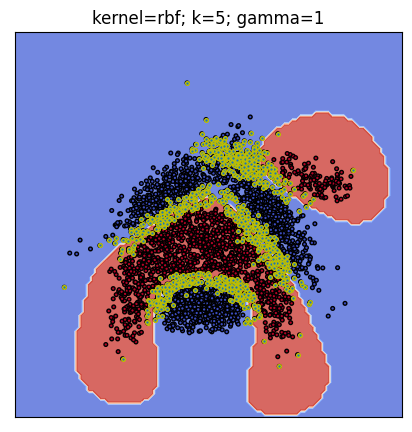

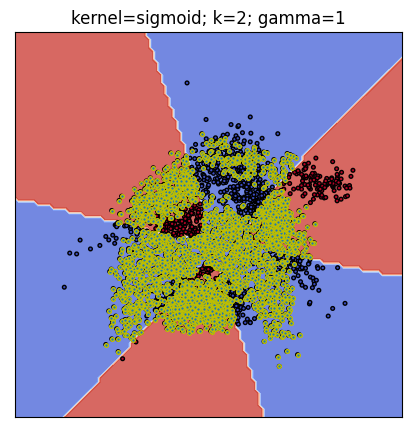

In [230]:
# Set-up 2x2 grid for plotting.
X, y = ds.X_train, ds.y_train
X0, X1 = X[:, 0], X[:, 1]

for clf, title in zip((best, worst), (titles[1], titles[9])):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
    )

    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=7, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=7, edgecolors="y")
    fig.savefig(f'{title}.png')

In [9]:
best_acc = 0
max_n = 30
best_n = 0
KNN = KNeighborsClassifier(n_neighbors=1)
for i in range (1, max_n+1):
    _KNN = KNeighborsClassifier(n_neighbors=i)
    _KNN.fit(ds.X_train, ds.y_train)
    acc = _KNN.score(ds.X_test, ds.y_test)
    if acc > best_acc:
        best_acc = acc
        best_n = i
        KNN = _KNN
print(f"Max accuracy for KNN with variation of neighbors 1 to {max_n}: {best_acc} with {best_n} neighbors.")

Max accuracy for KNN with variation of neighbors 1 to 30: 0.9069182389937107 with 23 neighbors.


In [17]:
mesh_size = .02
margin = 0.25

x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)
xx, yy = np.meshgrid(xrange, yrange)

Z = KNN.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)


# Plot the figure
fig = go.Figure(data=[
    go.Contour(
        x=xrange,
        y=yrange,
        z=Z,
        colorscale='RdBu'
    )
])
fig.update_layout(
    autosize=False,
    width=500,
    height=500,)
fig.to_image(format="png")
fig.show()

## Questão 2

In [18]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


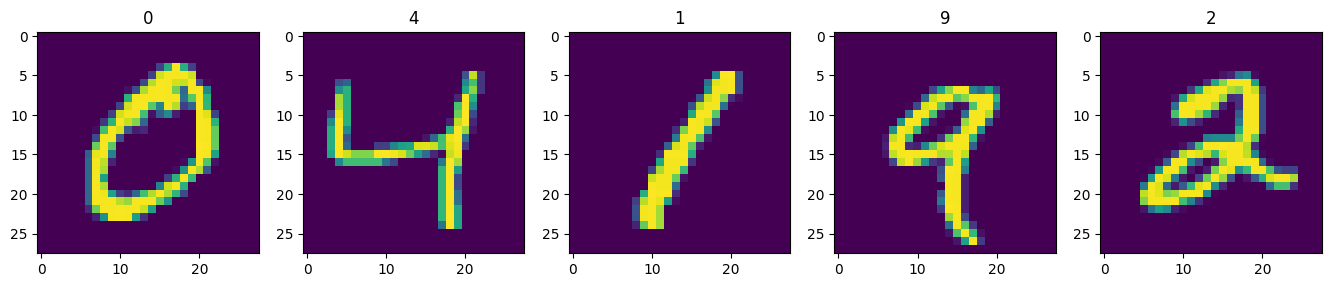

In [231]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset, [int(0.9 * len(mnist_testset)), int(0.1 * len(mnist_testset))])

train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))

# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img)
    plt.savefig(f'mnist_{i}.png')
plt.show()

In [76]:
model = Model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [77]:
no_epochs = 5

train_loss = []
val_loss = []

train_loss_per_iter = []
val_loss_per_iter = []

acc_per_epoch = []
train_acc_per_iter = []

best_val_loss = 1

for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    
    # training
    for itr, (image, label) in enumerate(train_dataloader):
        model.train()
        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        train_loss_per_iter.append(loss.item())
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        model.eval()
        train_acc = 0
        for itr, (image, label) in enumerate(test_dataloader):
            pred = model(image)
            pred = torch.nn.functional.softmax(pred, dim=1)
            for i, p in enumerate(pred):
                if label[i] == torch.max(p.data, 0)[1]:
                    train_acc+= 1
        train_acc_per_iter.append(train_acc / len(mnist_testset))


    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    # validation
    model.eval()
    total = 0
    for itr, (image, label) in enumerate(val_dataloader):

        pred = model(image)

        loss = criterion(pred, label)
        val_loss_per_iter.append(loss.item())
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total += 1

    accuracy = total / len(mnist_valset)
    acc_per_epoch.append(accuracy)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print(f"\nEpoch: {epoch + 1}/{no_epochs}, Train Loss: {total_train_loss:.8f}, Val Loss: {np.mean(val_loss):.8f}, Val Accuracy: {accuracy:.8f}")

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print(f"Saving the model state dictionary for Epoch: {epoch + 1} with Validation loss: {total_val_loss:.8f}")
        torch.save(model.state_dict(), "model.dth")



Epoch: 1/5, Train Loss: 7.88306090, Val Loss: 0.04904627, Val Accuracy: 0.98366667
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.04904627

Epoch: 2/5, Train Loss: 2.69060588, Val Loss: 0.04233780, Val Accuracy: 0.98866667
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.03562933

Epoch: 3/5, Train Loss: 2.09307622, Val Loss: 0.03788550, Val Accuracy: 0.98988889
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.02898089

Epoch: 4/5, Train Loss: 1.74039539, Val Loss: 0.03517122, Val Accuracy: 0.99066667
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.02702837

Epoch: 5/5, Train Loss: 1.45498430, Val Loss: 0.03341704, Val Accuracy: 0.99077778
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.02640034


In [242]:
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
objs = [train_acc, train_acc_per_iter, train_loss, train_loss_per_iter, val_loss, val_loss_per_iter, acc_per_epoch]
for i, obj in enumerate(objs):
    save_object(obj, f'obj_{i}.pkl')

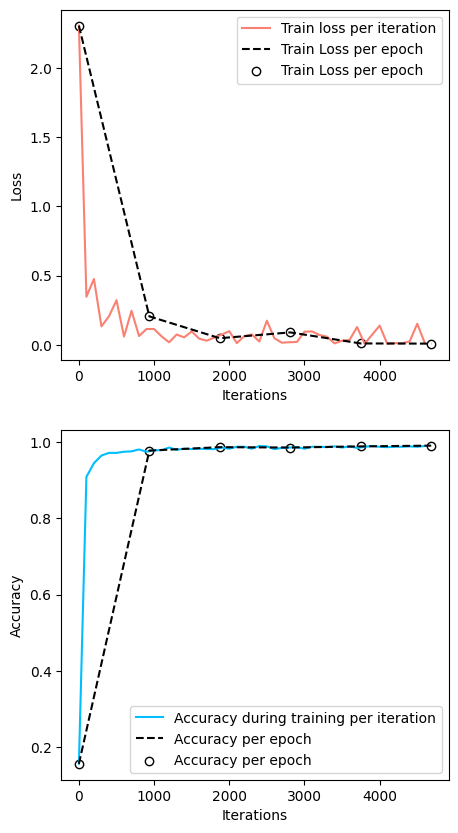

In [222]:
size=10
#plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss per epoch",  marker='o')
#plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss per epoch", marker='o')
fig, ax = plt.subplots(2, 1, figsize=(5, 10))
size = 100
ax[0].plot([i for i in range(0, len(train_loss_per_iter), size)],
[train_loss_per_iter[i] for i in range(0,len(train_loss_per_iter),size)],c='salmon', label="Train loss per iteration")

size2 = int(len(train_loss_per_iter)/len(train_loss)) -1
xp = [i for i in range(0, len(train_loss_per_iter), size2)]
yp = [train_loss_per_iter[i] for i in range(0,len(train_loss_per_iter),size2)]
ax[0].plot(xp,yp, label="Train Loss per epoch", linestyle='--', c='black')
ax[0].scatter(xp,yp,label="Train Loss per epoch", marker='o', edgecolors='black', c='white' )

ax[1].plot([i for i in range(len(train_acc_per_iter))[0::size]],[np.mean(i) for i in train_acc_per_iter[0::size]], c='deepskyblue',label="Accuracy during training per iteration")
xp = [i for i in range(0, len(train_acc_per_iter), size2)]
yp = [train_acc_per_iter[i] for i in range(0,len(train_acc_per_iter),size2)]
ax[1].plot(xp,yp, label="Accuracy per epoch", linestyle='--', c='black')
ax[1].scatter(xp,yp,label="Accuracy per epoch", marker='o', edgecolors='black', c='white' )

ax[0].set_xlabel("Iterations")
ax[1].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
ax[0].legend(loc='upper right')
ax[1].legend(loc='lower right')
plt.show()